# Modelo Rosenzweig-MacArthur

Un modelo razonable para las poblaciones de presas y depredadores a través del tiempo, considerando su interacción, podría tener esta forma:

$\dot{x}=$ tasa de nacimiento - tasa de muertes no debidas a $ y $ - tasa de muertes por depredación

$\dot{y}=$ tasa de reproducción - tasa de mortalidad

Donde $ x $ representa la densidad de presas (número de presas por unidad de área), y $ y $ la densidad de depredadores (número de depredadores por unidad de área).

Un modelo cualquiera es una elección de cómo computar estas tasas, así lo abstrae el modelo de **Rosenzweig-McArthur**:

$$\dot{x}=f(x)-\phi(x,y)$$

$$\dot{y}=-ey+k\phi(x,y)$$

Donde $f(x)$ es la tasa de cambio de $x$ cuando no hay depredación, $\phi(x, y)$ es la tasa de depredación, $ k $ la eficiencia con la que los depredadores asimilan a las presas y 
$ e $ la tasa de muertes del depredador ($ e, k>0 $).

La tasa de cambio de $ x $ (nacimientos y muertes de presas) podría modelarse como crecimiento Maltusiano $f(x)=\frac{dx}{dt}=rx\left(1-\frac{x}{K}\right)$, donde la tasa de reproducción es proporcional tanto al tamaño de la población actual como a la cantidad de recursos disponible ($ r,K>0 $). 

Si se asume que la tasa de muertes del depredador es lineal y su densidad no es tal que se interfieran entre sí para cazar, entonces sólo la cantidad de presas limita la población de depredadores. 

$$\dot{x}=rx\left(1-\frac{x}{K}\right)-y\phi(x)$$

$$\dot{y}=-ey+ky\phi(x)$$

$\phi(x)$ es la cantidad de presas atrapadas por depredador por unidad de tiempo, en función de la densidad de presas.

In [1]:
# cómputo simbólico con sympy
from sympy import *
init_printing()

# definimos qué variables usar como símbolos
x, y, e, phi, f, k, r, K = symbols('x y e phi f k r K')

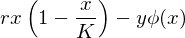

In [2]:
dx = r*x*(1-x/K) - y*phi(x)
dx

In [3]:
dy = -e*y + k*y*phi(x)
dy

## Tasa de depredación según Holling

Lo esencial es que la tasa de depredación esté en función sólo de la densidad de presas. [Este artículo](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf) discute la creación de tal función considerando el promedio de presas atrapadas a lo largo de un lapso extendido. El argumento $a$ modela el tiempo que le toma al depredador encontrar una presa, mientras que $b$ modela cuánto tiempo le toma atraparla, comérsela, digerirla, dormir la siesta, y empezar a acechar nuevamente.

$$\phi(x)=\frac{ax}{1+bx}$$

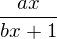

In [4]:
a, b = symbols('a b')
phi_holling = a*x / (1 + b*x)
phi_holling

In [5]:
# importamos bibliotecas para plotear
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# convertimos los símbolos de phi_holling en función ejecutable
phi_holling = lambdify((x, a, b), phi_holling)

Con un tiempo para encontrar presa de 20 unidades y un tiempo para consumirlas de 9 encontramos una curva parecida a la del [artículo de Hal L Smith](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf).

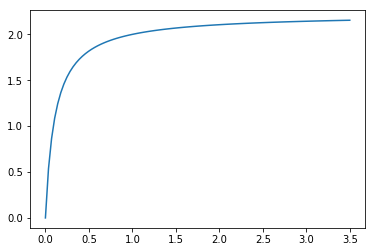

In [6]:
t_encontrar = 20
t_consumir = 9

presas = np.linspace(0, 3.5, 100)

# computamos depredaciones para un rango de densidades de presas
depredaciones = [phi_holling(n, 
                             t_encontrar,
                             t_consumir) 
                 for n in presas]

fig = plt.plot(presas, depredaciones)

## Otra tasa de depredación

Una curva parecida a la de Holling se obtiene "saturando" de presas el área que ocupa un depredador.

$$\phi(x)=x^{\frac{1}{k}}+\left(1-\frac{1}{k}\right)$$

Donde $k$ representa la saturación.

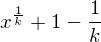

In [7]:
phi_garcia = x**(1/k)+(1-1/k)
phi_garcia

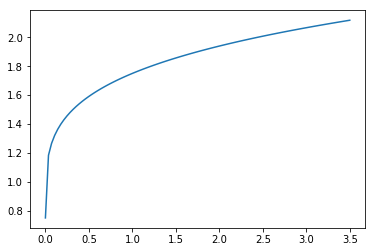

In [8]:
phi_garcia = lambdify((x, k), phi_garcia)
presas = np.linspace(0, 3.5, 100)
depredaciones = [phi_garcia(n, 4) for n in presas]
fig = plt.plot(presas, depredaciones)